# Movie 7

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2

movie7_path = "movies/movie7.avi"

## Functions for detecting edges

In [6]:
# Detect edges with OpenCV's findContours
# No longer used
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

# Detect edges by detecting the first occurrence of a minimum rectangular section where the mean pixel values exceeds a threshold
# Threshold differs for different movies

# check_section is used to calibrate and find the right parameters for a movie
def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

# Returns the left edge
def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

# Returns the right edge
def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

In [8]:
# This cell was used to generate frames used to calibrate and test parameters  
#movie_path = "movies/movie7.avi"
#utput_path = "movies/movie7"
#movie = cv2.VideoCapture(movie_path)
#count = 0
#while movie.isOpened():
#    count += 1
#    success, frame = movie.read()
#    if not success:
#        break
#    cv2.imwrite(f'{output_path}/frame{count}.jpg', frame)

#movie.release()
#cv2.destroyAllWindows()

In [10]:
#from skimage import io
#img_raw = io.imread("movies/movie7/frame1.jpg")
#img = img_raw[55:170,:]

#plt.imshow(img)

## Calibrate and estimate parameters for segments

### Algorithm to find left and right edges
- Break the grayed frame into a contibuous sequence of rectangles of width 'check_size'.
- Calculate mean pixel values of each rectangle
- Return the first rectangle whose mean pixel value exceeds the threshold value 'min_mean_pixel'

### Applying the algorithm
- The appropriate width of left edge is set to 40 and that of right edge set to 100 for this movie.
- Some correction values may also be used to include all pixels at edges

In [15]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie7_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

frame_index = 0 # Track frame number for fluorescent intensity table

while True:
    frame_index+=1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to isolate region of interest
        canvas = frame[55:170,:]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 10, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (5, 5), 0)

        edge_width = 5

        sections = check_sections(blur_frame, check_size=edge_width)
        # print("Frame:",frame_index)
        for mean_pixel, position, width in sections:
            # print("Mean pixels:", mean_pixel)
            cv2.rectangle(canvas, (position,0), (position+width,canvas.shape[0]), (255, 255, 0), 1)
        
        left_side = get_left_side(blur_frame, check_size=edge_width)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=18)
        
        left_side_thickness = 40
        right_side_thickness = 100
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side,0), 
                              (left_side+left_side_thickness, canvas.shape[0]), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness, 0),
                              (right_side, canvas.shape[0]),
                              (0, 0, 255), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side,0),
                              (right_side, canvas.shape[0]), 
                              (0, 255, 255), 1)

        cv2.imshow("Movie 7", canvas)


    # 1 frame per second
    if cv2.waitKey(500) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Mean pixels at edge as fluorescent intensity values
- The mean pixel values obtained with 'cv2.mean()' are used as fluorescent intensity values
- Each value in each frame is appended to the 'fluorescent_intensities' list which will be converted to a Pandas dataframe for analysis
- The position of the trailing edge (left side) is also included to represent the position of the cell in each frame.
- The relative change in position will be used as displacement and for calculating velocity
- The time interval between each frame is 30 minutes.

In [22]:
cap = cv2.VideoCapture(movie7_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("output7.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0 # Track frame number for fluorescent intensity table

fluorescent_intensities = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to isolate region of interest
        canvas = frame[55:170,:]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 10, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (5, 5), 0)

        edge_width = 5

        # Get trailing and leading bounding rectangle, and entire cell contour
        left_side = get_left_side(blur_frame, check_size=edge_width)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=18)

        left_side_thickness = 100
        right_side_thickness = 100
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side,0), 
                              (left_side+left_side_thickness, canvas.shape[0]), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,0), 
                              (right_side, canvas.shape[0]), 
                              (0, 0, 255), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side,0),
                              (right_side, canvas.shape[0]), 
                              (0, 255, 255), 1)

        
        # Calculate mean intensity at trailing edge
        trailing_edge = gray_frame[0:canvas.shape[0], left_side:left_side+left_side_thickness]
        trailing_edge_intensity = cv2.mean(trailing_edge)
        #print("Trailing Edge:", trailing_edge_intensity)

        # Calculate mean intensity at leading edge
        leading_edge = gray_frame[0:canvas.shape[0], right_side-right_side_thickness:right_side]
        leading_edge_intensity = cv2.mean(leading_edge)
        #print("Leading Edge:", leading_edge_intensity)

        # Append intensity data to list
        fluorescent_intensities.append([frame_index, 
                                        trailing_edge_intensity[0], # Left edge
                                        leading_edge_intensity[0],  # Right edge
                                        (frame_index*30)-30,        # Time (30 minutes interval)
                                        left_side])                # Position

        writer.write(canvas)

        cv2.imshow("Movie 7", canvas)

    else:
        break

    # 1 frame per second
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

## Calculate Displacements and Velocities

In [25]:
intensity_dataframe = pd.DataFrame(fluorescent_intensities, columns =  ["Frame", "Trailing", "Leading", "Time", "Position"])
# Displacement = All Positions - Starting position
intensity_dataframe["Displacement"] = intensity_dataframe["Position"] - intensity_dataframe["Position"][0]
# Time from minutes to seconds
intensity_dataframe["Time"] = intensity_dataframe["Time"] * 60
# Calculate velocity
# Velocity = displacement / time in seconds
intensity_dataframe["Displacement"].astype('float64')
intensity_dataframe["Time"].astype('float64')

intensity_dataframe["Average Velocity"] = intensity_dataframe["Displacement"] / intensity_dataframe["Time"]

instantaneous_distances = []
for idx in range(len(intensity_dataframe["Displacement"])):
    if idx > 0:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx]-intensity_dataframe["Displacement"][idx-1])
    else:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx])
        
intensity_dataframe["Instantaneous Displacement"] = pd.Series(instantaneous_distances)
intensity_dataframe["Instantaneous Velocity"] = intensity_dataframe["Instantaneous Displacement"] / 600

intensity_dataframe = intensity_dataframe.fillna(0)
intensity_dataframe

,Frame,Trailing,Leading,Time,Position,Displacement,Average Velocity,Instantaneous Displacement,Instantaneous Velocity
0,1,4.026261,5.621826,0,85,0,0.000000,0,0.000000
1,2,4.371826,5.699304,1800,100,15,0.008333,15,0.025000
2,3,4.337652,5.440957,3600,100,15,0.004167,0,0.000000
3,4,4.235130,5.781391,5400,95,10,0.001852,-5,-0.008333
4,5,4.133565,5.498174,7200,95,10,0.001389,0,0.000000
...,...,...,...,...,...,...,...,...,...
82,83,3.452000,5.234174,147600,125,40,0.000271,0,0.000000
83,84,3.377913,5.211043,149400,125,40,0.000268,0,0.000000
84,85,3.329826,5.361739,151200,130,45,0.000298,5,0.008333
85,86,2.367043,5.521478,153000,100,15,0.000098,-30,-0.050000


## Plot fluorescent intensities at region of interest. That is, Leading edge (Right side)

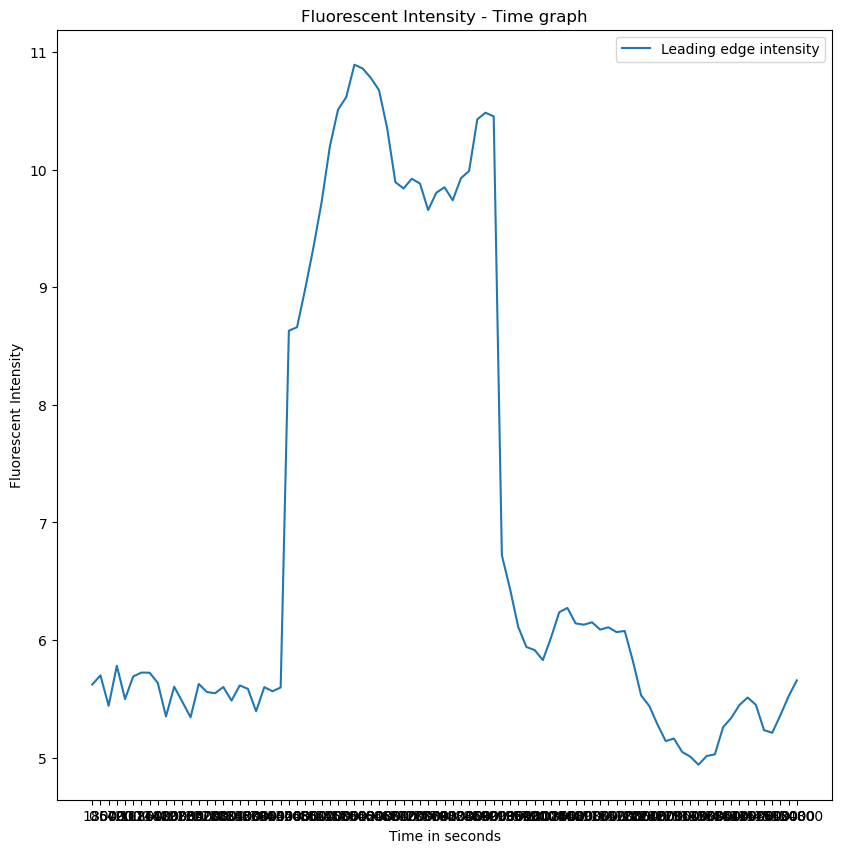

In [28]:
plt.figure(figsize=(10,10))
# plt.plot(intensity_dataframe.Time, intensity_dataframe.Trailing, label="Trailing edge intensity")
plt.plot(intensity_dataframe.Time, intensity_dataframe.Leading, label="Leading edge intensity")

plt.title("Fluorescent Intensity - Time graph")
plt.ylabel("Fluorescent Intensity")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

## Displacement over time

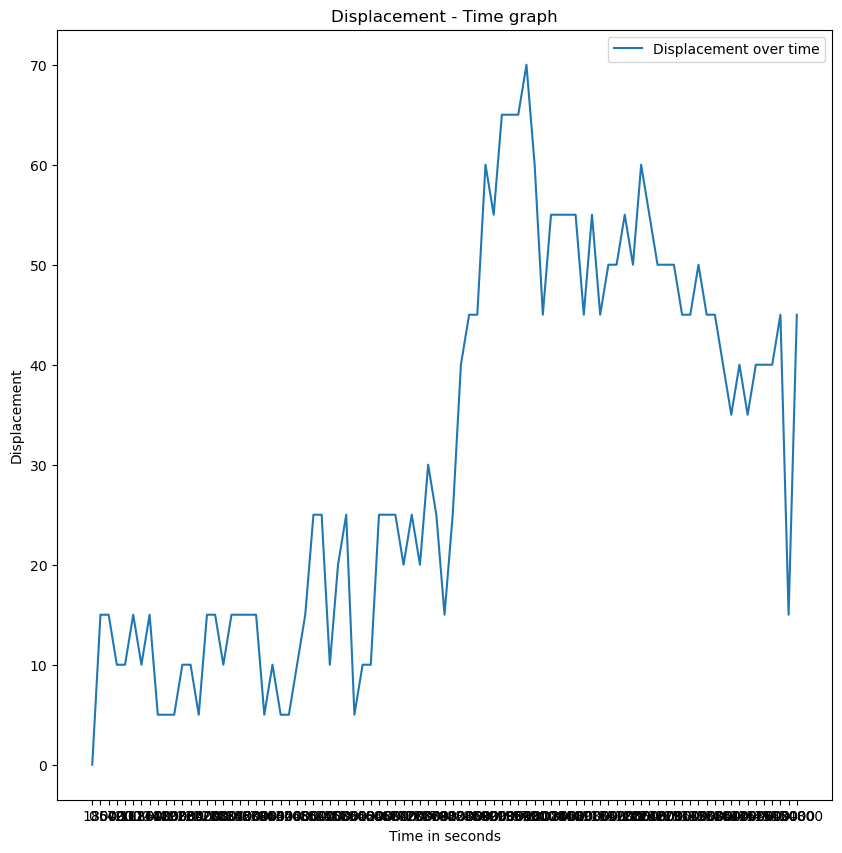

In [31]:
plt.figure(figsize=(10,10))
plt.plot(intensity_dataframe.Time, intensity_dataframe["Displacement"], label="Displacement over time")

plt.title("Displacement - Time graph")
plt.ylabel("Displacement")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

## Stimulation of RhoA activity at Leading Edge of SWELL1-depleted cells Fails to change Cell direction
- Optogenetic stimulation of RhoA activity at the leading edge of SWELL1-depleted MDA-MB-231 cells migrating inside 10 × 10 µm2 microchannels causes a transient retraction of the cell front but fails to reverse their migration direction